In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Feb  8 14:39:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
|  0%   56C    P0              73W / 450W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 16
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'uniform', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.11407470703125
encoder.convs 5.989013671875
encoder.linear 0.12506103515625
prior 0.0
latent 0.0
decoder 6.153697967529297
decoder.linear 0.1328125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.08-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 37784
-rw-rw-r-- 1 scpark scpark    22424  2월  8 14:36 events.out.tfevents.1707370444.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 38662636  2월  8 14:35 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


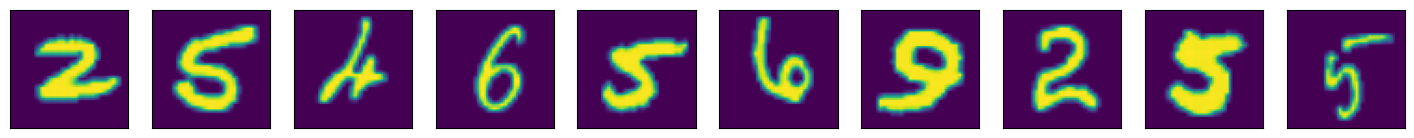

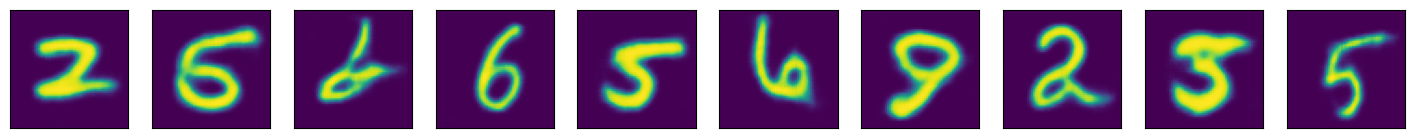

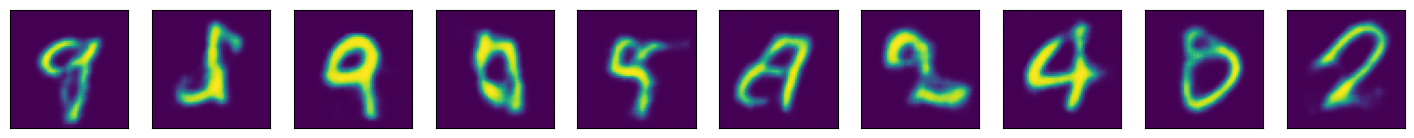

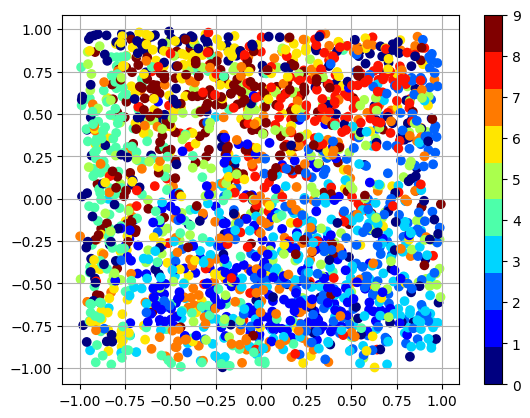

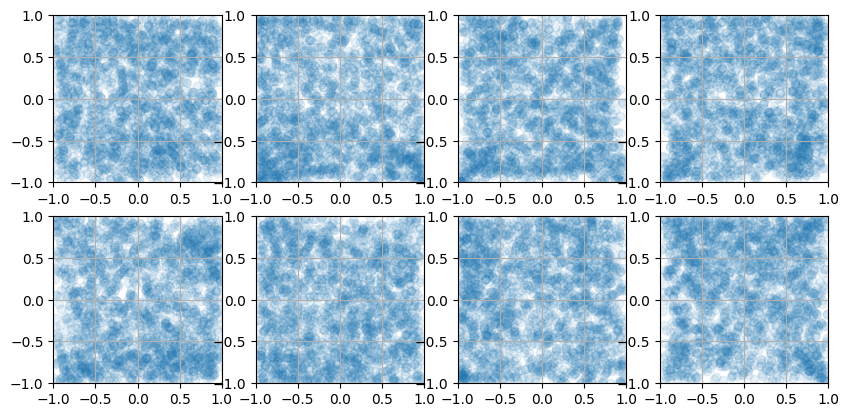

3001
mmd_loss 0.008728057146072388
recon_loss 0.025096796452999115
3002
mmd_loss 0.0010266900062561035
recon_loss 0.02567271888256073
3003
mmd_loss 0.0026601850986480713
recon_loss 0.024020319804549217
3004
mmd_loss 0.004098117351531982
recon_loss 0.026120226830244064
3005
mmd_loss 0.005028665065765381
recon_loss 0.025786202400922775
3006
mmd_loss 0.004653573036193848
recon_loss 0.026181166991591454
3007
mmd_loss 0.006050199270248413
recon_loss 0.029165616258978844
3008
mmd_loss 0.014329969882965088
recon_loss 0.025169795379042625
3009
mmd_loss 0.0008330643177032471
recon_loss 0.023518851026892662
3010
mmd_loss -0.005398541688919067
recon_loss 0.02541816607117653
3011
mmd_loss 0.0004412531852722168
recon_loss 0.024974506348371506
3012
mmd_loss 0.0012600719928741455
recon_loss 0.026001159101724625
3013
mmd_loss 0.004124462604522705
recon_loss 0.025683175772428513
3014
mmd_loss 0.001323312520980835
recon_loss 0.025255439803004265
3015
mmd_loss 0.000425487756729126
recon_loss 0.0274489074

3124
mmd_loss 0.0023790597915649414
recon_loss 0.028037188574671745
3125
mmd_loss 0.0013374388217926025
recon_loss 0.026079025119543076
3126
mmd_loss 0.006386131048202515
recon_loss 0.026064377278089523
3127
mmd_loss -0.001646190881729126
recon_loss 0.025375600904226303
3128
mmd_loss 0.0034834742546081543
recon_loss 0.02498636208474636
3129
mmd_loss 0.004768997430801392
recon_loss 0.02582419477403164
3130
mmd_loss 0.002300858497619629
recon_loss 0.026632148772478104
3131
mmd_loss 0.00043204426765441895
recon_loss 0.02367222309112549
3132
mmd_loss -0.0027299225330352783
recon_loss 0.022943705320358276
3133
mmd_loss 0.0025799572467803955
recon_loss 0.026693325489759445
3134
mmd_loss 0.002283751964569092
recon_loss 0.024694299325346947
3135
mmd_loss 0.0038219094276428223
recon_loss 0.023399855941534042
3136
mmd_loss -1.8835067749023438e-05
recon_loss 0.022859204560518265
3137
mmd_loss 0.0012219548225402832
recon_loss 0.025711094960570335
3138
mmd_loss 0.0047973692417144775
recon_loss 0.02

3247
mmd_loss -0.0012050271034240723
recon_loss 0.026002606377005577
3248
mmd_loss 0.0032816529273986816
recon_loss 0.02516889199614525
3249
mmd_loss -0.0021899640560150146
recon_loss 0.02438582479953766
3250
mmd_loss 0.0027785301208496094
recon_loss 0.022897228598594666
3251
mmd_loss 0.0024397969245910645
recon_loss 0.02484160289168358
3252
mmd_loss 0.0009976625442504883
recon_loss 0.025849660858511925
3253
mmd_loss 0.002516508102416992
recon_loss 0.024002373218536377
3254
mmd_loss 0.004448622465133667
recon_loss 0.024174025282263756
3255
mmd_loss -0.0007711350917816162
recon_loss 0.02490631863474846
3256
mmd_loss -0.00013208389282226562
recon_loss 0.02433498203754425
3257
mmd_loss -0.002144157886505127
recon_loss 0.024172108620405197
3258
mmd_loss -0.0019995272159576416
recon_loss 0.026217371225357056
3259
mmd_loss 0.009649902582168579
recon_loss 0.02651599794626236
3260
mmd_loss -0.001094818115234375
recon_loss 0.024816414341330528
3261
mmd_loss -0.0032556653022766113
recon_loss 0.0

3371
mmd_loss 0.0020215511322021484
recon_loss 0.02544284425675869
3372
mmd_loss 0.0026214122772216797
recon_loss 0.025261934846639633
3373
mmd_loss 0.0023217499256134033
recon_loss 0.026864033192396164
3374
mmd_loss 0.005944401025772095
recon_loss 0.025324370712041855
3375
mmd_loss 0.005458354949951172
recon_loss 0.024598803371191025
3376
mmd_loss -0.000734180212020874
recon_loss 0.024713046848773956
3377
mmd_loss 0.003435671329498291
recon_loss 0.025692250579595566
3378
mmd_loss -0.0019070208072662354
recon_loss 0.025111421942710876
3379
mmd_loss 0.0029938220977783203
recon_loss 0.02432418428361416
3380
mmd_loss 0.005246281623840332
recon_loss 0.02443580888211727
3381
mmd_loss 0.004487663507461548
recon_loss 0.025712862610816956
3382
mmd_loss 0.0016117095947265625
recon_loss 0.026075202971696854
3383
mmd_loss 0.001295924186706543
recon_loss 0.02211473509669304
3384
mmd_loss 0.007455587387084961
recon_loss 0.02513553760945797
3385
mmd_loss 0.0010836422443389893
recon_loss 0.0266401544

3494
mmd_loss -0.00010398030281066895
recon_loss 0.0240812748670578
3495
mmd_loss -0.0011036098003387451
recon_loss 0.024219518527388573
3496
mmd_loss 0.0016442835330963135
recon_loss 0.025226067751646042
3497
mmd_loss 0.002430468797683716
recon_loss 0.025382596999406815
3498
mmd_loss 0.0018085241317749023
recon_loss 0.025763381272554398
3499
mmd_loss -0.003986984491348267
recon_loss 0.024158697575330734
3500
mmd_loss -0.00011089444160461426
recon_loss 0.024578597396612167
3501
mmd_loss 8.821487426757812e-06
recon_loss 0.023140504956245422
3502
mmd_loss 0.004042685031890869
recon_loss 0.025781234726309776
3503
mmd_loss 0.0007021725177764893
recon_loss 0.026153162121772766
3504
mmd_loss 0.0010187327861785889
recon_loss 0.025270311161875725
3505
mmd_loss 0.003280460834503174
recon_loss 0.02526954561471939
3506
mmd_loss -0.000711292028427124
recon_loss 0.023607950657606125
3507
mmd_loss 0.004701346158981323
recon_loss 0.025992168113589287
3508
mmd_loss 0.0004563629627227783
recon_loss 0.0

3618
mmd_loss -0.0009837448596954346
recon_loss 0.022142808884382248
3619
mmd_loss -0.00264701247215271
recon_loss 0.02363651990890503
3620
mmd_loss 0.0011724233627319336
recon_loss 0.023969104513525963
3621
mmd_loss -0.0017536580562591553
recon_loss 0.02298547886312008
3622
mmd_loss 0.002512216567993164
recon_loss 0.022821009159088135
3623
mmd_loss 0.004378557205200195
recon_loss 0.0234399251639843
3624
mmd_loss -0.0007283389568328857
recon_loss 0.023658469319343567
3625
mmd_loss 0.004179954528808594
recon_loss 0.021098941564559937
3626
mmd_loss 0.005128800868988037
recon_loss 0.023367460817098618
3627
mmd_loss -3.8295984268188477e-05
recon_loss 0.02367892861366272
3628
mmd_loss 0.001712024211883545
recon_loss 0.025263583287596703
3629
mmd_loss 0.004990726709365845
recon_loss 0.02409578114748001
3630
mmd_loss -0.0017664432525634766
recon_loss 0.02507254108786583
3631
mmd_loss -0.0023153722286224365
recon_loss 0.023476457223296165
3632
mmd_loss 0.004433870315551758
recon_loss 0.0228524

3741
mmd_loss 0.0052353739738464355
recon_loss 0.026423078030347824
3742
mmd_loss 0.00025978684425354004
recon_loss 0.02481747977435589
3743
mmd_loss 0.0026164352893829346
recon_loss 0.023217719048261642
3744
mmd_loss -0.0034106671810150146
recon_loss 0.023958515375852585


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()